In [2]:
from nf_utils import UNAF, evaluate_flow, NAF, NSF, flow_losses, make_24h_forecast_with_bands
from utils_data import GEFcomWindLoader, create_wind_dataset
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    torch.cuda.init()
    _ = torch.empty(1, device='cuda')  # pre-warm context

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
dataset = create_wind_dataset()


In [5]:
train_dataset = dataset[dataset["TIMESTAMP"] < "2013-11-01 01:00:00"]
prediction_dataset = dataset[dataset["TIMESTAMP"] >= "2013-11-01 01:00:00"]

In [6]:
train_loader = GEFcomWindLoader(train_dataset.copy())
train_dataloader, validation_dataloader, test_dataloader = train_loader.get_dataloaders(
                                                                batch_size=32, shuffle=True, use_gpu=True,
                                                                test_size=0.1, validation_size=0.5
                                                                )

In [7]:
c_dim = train_loader.context_dim
c_dim

252

In [8]:
# flow = UNAF(x_dim=24, c_dim=c_dim, hidden_features=[16, 16], signal=8)
# flow.fit(train_dataloader, validation_dataloader=validation_dataloader, epochs=5, lr=1e-3, patience=20, device=device, save_path='UNAF')
flow = UNAF(x_dim=24, c_dim=c_dim, hidden_features=[16, 16], signal=8).load_from('UNAF')

In [ ]:
evaluate_flow(flow, test_dataloader, 'UNAF', 'UNAF_EVALUATION.json')

In [ ]:
unaf_losses = flow_losses(flow, test_dataloader)

In [ ]:
prediction_loader = GEFcomWindLoader(prediction_dataset.copy())
dataset = prediction_loader.create_dataset(shuffle=False)

In [ ]:
dataset[dataset['ZONE_1'] == 1]

In [ ]:
dataset.drop(columns=['TARGETVAR' + str(h) for h in range(1, 25)]).values

In [ ]:
c = dataset.drop(columns=['TARGETVAR' + str(h) for h in range(1, 25)]).values[:3,:]
c = torch.from_numpy(c).to(torch.float)
Q1, median, Q3 = make_24h_forecast_with_bands(flow, c)

In [ ]:
Q1

In [ ]:
Q1.reshape(-1)

In [ ]:
dataset.index[:2]

In [9]:
dataset = create_wind_dataset()
dataset[dataset["TIMESTAMP"] >= "2013-11-29 01:00:00"]

,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,ZONE_1,ZONE_2,ZONE_3,ZONE_4,ZONE_5,ZONE_6,ZONE_7,ZONE_8,ZONE_9,ZONE_10
16752,2013-11-29 01:00:00,0.365251,-2.345804,5.253364,-3.316089,7.177710,0,0,0,0,0,0,0,1,0,0
16753,2013-11-29 02:00:00,0.376323,-1.947233,5.283321,-2.758298,7.155574,0,0,0,0,0,0,0,1,0,0
16754,2013-11-29 03:00:00,0.357343,-1.357589,5.184671,-1.994448,6.952995,0,0,0,0,0,0,0,1,0,0
16755,2013-11-29 04:00:00,0.299185,-0.857674,5.118560,-1.379447,6.804751,0,0,0,0,0,0,0,1,0,0
16756,2013-11-29 05:00:00,0.295656,-1.024312,5.330838,-1.604577,7.103252,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,2013-11-30 20:00:00,0.964501,-3.027038,-7.943936,-4.218224,-13.516870,0,0,0,0,0,1,0,0,0,0
16796,2013-11-30 21:00:00,0.957410,-2.968589,-7.673589,-4.048812,-13.004413,0,0,0,0,0,1,0,0,0,0
16797,2013-11-30 22:00:00,0.928576,-3.643554,-7.348469,-5.040144,-11.809111,0,0,0,0,0,1,0,0,0,0
16798,2013-11-30 23:00:00,0.649307,-2.035407,-6.429391,-2.705541,-9.374619,0,0,0,0,0,1,0,0,0,0


In [10]:
dataset = create_wind_dataset()
train_dataset = dataset[dataset["TIMESTAMP"] < "2013-11-01 01:00:00"]
prediction_dataset = dataset[dataset["TIMESTAMP"] >= "2013-11-01 01:00:00"]

train_loader = GEFcomWindLoader(train_dataset.copy())

train_dataloader, validation_dataloader, test_dataloader = train_loader.get_dataloaders(
                                                                batch_size=32, shuffle=True, use_gpu=True, test_size=0.1, validation_size=0.5
                                                                )
prediction_loader = GEFcomWindLoader(prediction_dataset.copy(), x_scaler=train_loader.x_scaler, y_scaler=train_loader.y_scaler)

prediction_dataloader, _, _ = prediction_loader.get_dataloaders(
                                            batch_size=32, use_gpu=True, shuffle=False, 
                                            test_size=0.0, validation_size=0.0
                                            )

In [34]:
prediction_loader.dataframe

,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,ZONE_1,ZONE_2,ZONE_3,ZONE_4,...,ZONE_7,ZONE_8,ZONE_9,ZONE_10,ws10,ws100,we10,we100,wd10,wd100
16080,2013-11-01 01:00:00,0.022187,2.075134,-1.366583,2.572392,-1.953506,0,0,0,0,...,0,1,0,0,2.484699,3.230075,7.669933,16.850311,-33.366976,-37.213485
16081,2013-11-01 02:00:00,0.048181,2.692455,-0.498385,3.379303,-0.923241,0,0,0,0,...,0,1,0,0,2.738193,3.503150,10.265072,21.495442,-10.486997,-15.280567
16082,2013-11-01 03:00:00,0.057793,2.522367,-0.354914,3.131421,-0.774903,0,0,0,0,...,0,1,0,0,2.547214,3.225875,8.263542,16.784666,-8.009311,-13.899213
16083,2013-11-01 04:00:00,0.009973,2.318911,-0.343121,2.854207,-0.789238,0,0,0,0,...,0,1,0,0,2.344159,2.961316,6.440668,12.984473,-8.416792,-15.457048
16084,2013-11-01 05:00:00,0.014357,2.581689,-0.151499,3.237820,-0.543670,0,0,0,0,...,0,1,0,0,2.586130,3.283148,8.648111,17.694619,-3.358380,-9.531743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,2013-11-30 20:00:00,0.964501,-3.027038,-7.943936,-4.218224,-13.516870,0,0,0,0,...,0,0,0,0,8.501122,14.159773,307.184120,1419.511446,-110.859347,-107.331633
16796,2013-11-30 21:00:00,0.957410,-2.968589,-7.673589,-4.048812,-13.004413,0,0,0,0,...,0,0,0,0,8.227788,13.620119,278.496167,1263.318009,-111.149356,-107.293528
16797,2013-11-30 22:00:00,0.928576,-3.643554,-7.348469,-5.040144,-11.809111,0,0,0,0,...,0,0,0,0,8.202164,12.839710,275.902280,1058.365411,-116.373358,-113.112854
16798,2013-11-30 23:00:00,0.649307,-2.035407,-6.429391,-2.705541,-9.374619,0,0,0,0,...,0,0,0,0,6.743882,9.757224,153.355689,464.460587,-107.566669,-106.098288


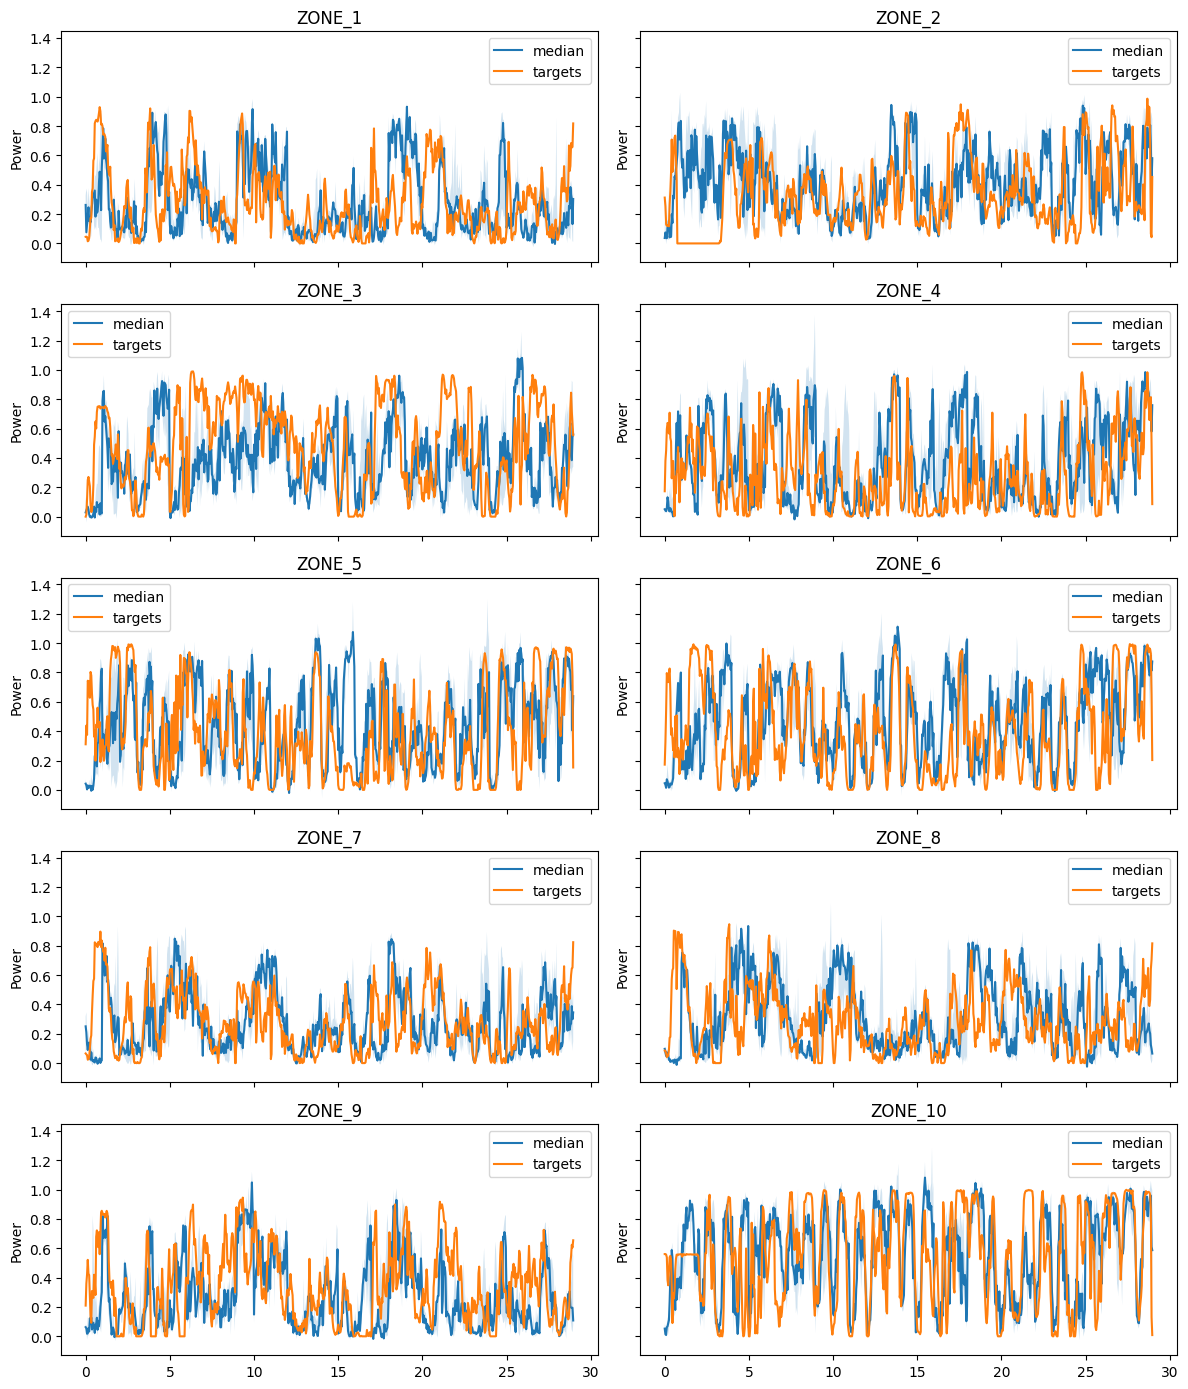

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt 

dataset = prediction_loader.create_dataset(shuffle=False)
target_names = ['TARGETVAR' + str(h) for h in range(1, 25)]
zones = ['ZONE_' + str(i) for i in range(1, 10 + 1)]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,14), sharex=True, sharey=True)
axes = axes.flatten()

pbar = tqdm(zones, desc="Zones", leave=False)
for axe, zone in zip(axes, pbar):
    df_zone = dataset[dataset[zone] == 1]
    targets = df_zone[target_names].values.reshape(-1)
    contexts = df_zone.drop(columns=target_names)
    contexts_scaled = prediction_loader.x_scaler.transform(contexts)
    c = torch.from_numpy(contexts_scaled).to(torch.float)
    Q1, median, Q3 = make_24h_forecast_with_bands(flow, c, samples=5)
    Q1 = prediction_loader.y_scaler.inverse_transform(Q1).reshape(-1)
    median = prediction_loader.y_scaler.inverse_transform(median).reshape(-1)
    Q3 = prediction_loader.y_scaler.inverse_transform(Q3).reshape(-1)

    axe.fill_between(np.arange(len(targets))/24, Q1, Q3, alpha=0.2)
    axe.plot(np.arange(len(targets))/24, median, label='median')
    axe.plot(np.arange(len(targets))/24, targets, label='targets')
    axe.set_title(zone)
    axe.legend()
    axe.set_ylabel('Power')

plt.tight_layout()
plt.show()

In [1]:
700/24

29.166666666666668